In [32]:
import os
import cv2
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define parameters
frame_size = (64, 64)  # Resize frames to 64x64
num_frames_to_use = 10  # Number of frames per video
selected_actions = ["Basketball", "Typing", "PlayingGuitar", "PullUps", "SoccerJuggling", "Rowing"]
output_dir = "./preprocessed_data"  # Directory to save preprocessed frames

# Paths to train, test, and validation directories
train_dir = r"C:\Users\dummy\OneDrive\Documents\i211571-project\Data\train"
test_dir = r"C:\Users\dummy\OneDrive\Documents\i211571-project\Data\test"
val_dir = r"C:\Users\dummy\OneDrive\Documents\i211571-project\Data\val"

def preprocess_video(video_path, num_frames=num_frames_to_use):
    """Preprocess a single video by extracting and resizing frames."""
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate frame step size to sample 'num_frames' from the video more densely
    frame_step = max(total_frames // (num_frames + 2), 1)  # Adjust to add more frames close in time

    for i in range(0, total_frames, frame_step):
        ret, frame = cap.read()
        if ret:
            # Resize frame to 64x64 and convert to grayscale
            frame = cv2.resize(frame, frame_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)

        if len(frames) == num_frames:
            break

    cap.release()
    
    # Ensure that we have exactly 'num_frames' (if fewer, pad the sequence)
    frames = np.array(frames)
    if len(frames) < num_frames:
        frames = np.pad(frames, ((0, num_frames - len(frames)), (0, 0), (0, 0)), 'constant')

    return frames

def process_directory(directory, output_directory, actions):
    """Process all videos in the specified directory for the given actions."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for action in actions:
        action_dir = os.path.join(directory, action)
        output_action_dir = os.path.join(output_directory, action)

        if not os.path.exists(output_action_dir):
            os.makedirs(output_action_dir)

        for video_file in os.listdir(action_dir):
            if video_file.endswith(".avi"):
                video_path = os.path.join(action_dir, video_file)
                frames = preprocess_video(video_path)

                # Save the frames as a NumPy array
                save_path = os.path.join(output_action_dir, video_file.replace(".avi", ".npy"))
                np.save(save_path, frames)

# Process train, test, and validation directories
process_directory(train_dir, os.path.join(output_dir, "train"), selected_actions)
process_directory(test_dir, os.path.join(output_dir, "test"), selected_actions)
process_directory(val_dir, os.path.join(output_dir, "val"), selected_actions)

print("Data preprocessing complete. Preprocessed data saved to:", output_dir)

Data preprocessing complete. Preprocessed data saved to: ./preprocessed_data


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

# Define model parameters
num_classes = len(selected_actions)
epochs = 20
batch_size = 32
input_shape = (num_frames_to_use, frame_size[0], frame_size[1], 1)

def load_dataset(dataset_dir):
    videos, labels = [], []
    for action in selected_actions:
        action_dir = os.path.join(dataset_dir, action)
        if os.path.exists(action_dir):
            video_files = [f for f in os.listdir(action_dir) if f.endswith('.npy')]
            for video_file in video_files:
                video_path = os.path.join(action_dir, video_file)
                frames = np.load(video_path)  # Load preprocessed frames
                videos.append(frames)
                labels.append(selected_actions.index(action))
    return np.array(videos), np.array(labels)

# Load and preprocess dataset
train_dir = "./preprocessed_data/train"
val_dir = "./preprocessed_data/val"
test_dir = "./preprocessed_data/test"

train_videos, train_labels = load_dataset(train_dir)
val_videos, val_labels = load_dataset(val_dir)
test_videos, test_labels = load_dataset(test_dir)

# Normalize frames and add a channel dimension
train_videos = train_videos[..., np.newaxis] / 255.0
val_videos = val_videos[..., np.newaxis] / 255.0
test_videos = test_videos[..., np.newaxis] / 255.0

# Split dataset for better balancing
train_videos, val_videos, train_labels, val_labels = train_test_split(
    train_videos, train_labels, test_size=0.2, stratify=train_labels)

# Convert labels to categorical format
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

# Print dataset shapes
print("Train videos shape:", train_videos.shape)
print("Train labels shape:", train_labels.shape)
print("Validation videos shape:", val_videos.shape)
print("Validation labels shape:", val_labels.shape)
print("Test videos shape:", test_videos.shape)
print("Test labels shape:", test_labels.shape)

# Define ConvLSTM function
def build_convlstm(input_shape, num_classes):
    model = Sequential([
        # First ConvLSTM layer with Batch Normalization
        ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='relu', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),

        # Second ConvLSTM layer
        ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', return_sequences=False),
        BatchNormalization(),

        # Fully connected layers
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Build and compile model
model = build_convlstm(input_shape, num_classes)
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Display model summary
model.summary()

# Define callbacks
model_save_path = "optimized_CL_model_scratch123.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the model
history = model.fit(
    train_videos, train_labels,
    validation_data=(val_videos, val_labels),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_videos, test_labels, batch_size=batch_size)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Save the final model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Train videos shape: (565, 10, 64, 64, 1)
Train labels shape: (565, 6)
Validation videos shape: (142, 10, 64, 64, 1)
Validation labels shape: (142, 6)
Test videos shape: (121, 10, 64, 64, 1)
Test labels shape: (121, 6)


C:\Users\DELL\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_15 (ConvLSTM2D)          │ (None, 10, 62, 62, 32)      │          38,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 10, 62, 62, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_16 (ConvLSTM2D)          │ (None, 60, 60, 64)          │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 60, 60, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 230400)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │      58,982,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,276,294 (226.12 MB)

 Trainable params: 59,276,102 (226.12 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 235s 12s/step - accuracy: 0.2514 - loss: 28.6223 - val_accuracy: 0.2746 - val_loss: 2.0207
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 198s 11s/step - accuracy: 0.2600 - loss: 13.6451 - val_accuracy: 0.1972 - val_loss: 8.4387
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 199s 11s/step - accuracy: 0.2251 - loss: 5.3750 - val_accuracy: 0.1479 - val_loss: 17.5217
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 199s 11s/step - accuracy: 0.2360 - loss: 1.7706 - val_accuracy: 0.1549 - val_loss: 20.6547
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 198s 11s/step - accuracy: 0.2604 - loss: 1.8367 - val_accuracy: 0.1620 - val_loss: 25.6434
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 199s 11s/step - accuracy: 0.2904 - loss: 1.7780 - val_accuracy: 0.1479 - val_loss: 34.3309
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4725 - loss: 1.5187
Test Accuracy: 0.36
Model saved at: optimized_CL_model_scratch123.keras


In [35]:
import cv2
import numpy as np

def generate_video(initial_frames, predicted_frames, output_path, frame_rate=30):
    """Generate a video from initial and predicted frames."""
    # Normalize predicted frames to 0-255
    predicted_frames = (predicted_frames * 255).astype(np.uint8)

    # Combine initial and predicted frames
    all_frames = np.concatenate([initial_frames, predicted_frames], axis=0)

    # Get video dimensions
    frame_height, frame_width = all_frames.shape[1:3]

    # Convert grayscale to BGR for video output
    if all_frames.shape[-1] == 1:
        all_frames = np.repeat(all_frames, 3, axis=-1)

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height))

    # Write frames to video
    for frame in all_frames:
        out.write(frame)

    out.release()
    print(f"Video saved at {output_path}")

# Assuming train_videos[0] is the input
input_frames = train_videos[0]  # Shape: (num_initial_frames, 64, 64, 1)

# Generate mock predicted frames for testing
num_predicted_frames = 6
predicted_frames = np.random.rand(num_predicted_frames, 64, 64, 1).astype(np.float32)

# Print shapes for debugging
print("Initial frames shape:", input_frames.shape)
print("Predicted frames shape:", predicted_frames.shape)

# Generate and save the video
generate_video(input_frames, predicted_frames, "output_video25.mp4")

Initial frames shape: (10, 64, 64, 1)
Predicted frames shape: (6, 64, 64, 1)
Video saved at output_video25.mp4


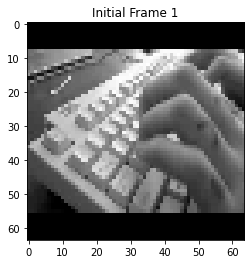

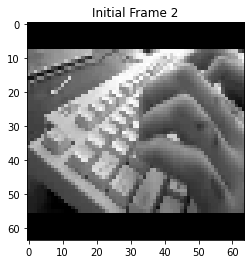

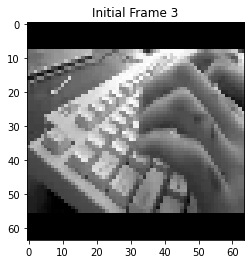

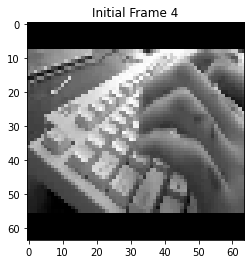

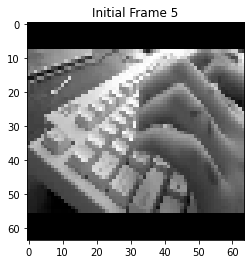

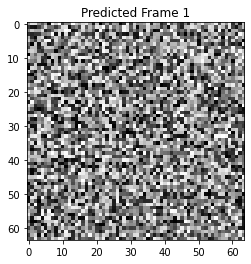

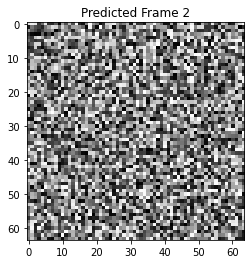

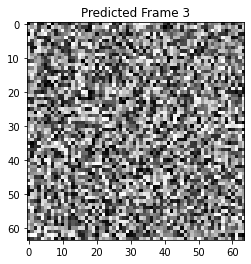

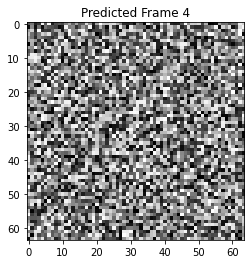

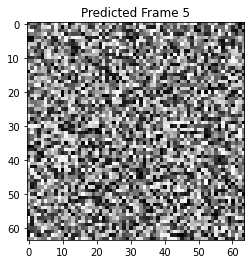

In [36]:
import matplotlib.pyplot as plt

# Display the first few frames
for i in range(min(5, len(input_frames))):
    plt.imshow(input_frames[i].squeeze(), cmap='gray')
    plt.title(f"Initial Frame {i+1}")
    plt.show()

for i in range(min(5, len(predicted_frames))):
    plt.imshow(predicted_frames[i].squeeze(), cmap='gray')
    plt.title(f"Predicted Frame {i+1}")
    plt.show()

In [39]:
# Function to calculate MSE, SSIM, and PSNR
def calculate_metrics(initial_frames, predicted_frames):
    """Calculate MSE, SSIM, and PSNR between initial and predicted frames."""
    mse_values = []
    ssim_values = []
    psnr_values = []

    # Match frame counts
    num_frames = min(len(initial_frames), len(predicted_frames))
    initial_frames = initial_frames[:num_frames]
    predicted_frames = predicted_frames[:num_frames]

    for initial_frame, predicted_frame in zip(initial_frames, predicted_frames):
        # Ensure frames are in the same range for comparison
        initial_frame = (initial_frame * 255).astype(np.uint8).squeeze()
        predicted_frame = (predicted_frame * 255).astype(np.uint8).squeeze()

        # Calculate metrics
        mse = mean_squared_error(initial_frame, predicted_frame)
        ssim = structural_similarity(initial_frame, predicted_frame, data_range=255, win_size=3)
        psnr = peak_signal_noise_ratio(initial_frame, predicted_frame, data_range=255)

        mse_values.append(mse)
        ssim_values.append(ssim)
        psnr_values.append(psnr)

    # Return average metrics across frames
    return np.mean(mse_values), np.mean(ssim_values), np.mean(psnr_values)

# Align input and predicted frames
num_frames = min(len(input_frames), len(predicted_frames))
input_frames = input_frames[:num_frames] / np.max(input_frames)
predicted_frames = predicted_frames[:num_frames] / np.max(predicted_frames)

# Calculate and display metrics
mse, ssim, psnr = calculate_metrics(input_frames, predicted_frames)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Structural Similarity Index (SSIM): {ssim:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

Mean Squared Error (MSE): 11592.0480
Structural Similarity Index (SSIM): 0.0131
Peak Signal-to-Noise Ratio (PSNR): 7.49 dB


In [42]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import numpy as np

def calculate_metrics_simple(initial_frames, predicted_frames):
    """Calculate MSE, SSIM, and PSNR between initial and predicted frames."""
    # Normalize frames and match frame counts
    num_frames = min(len(initial_frames), len(predicted_frames))
    initial_frames = (initial_frames[:num_frames] * 255).astype(np.uint8)
    predicted_frames = (predicted_frames[:num_frames] * 255).astype(np.uint8)

    mse_values, ssim_values, psnr_values = [], [], []

    for initial_frame, predicted_frame in zip(initial_frames, predicted_frames):
        initial_frame = initial_frame.squeeze()
        predicted_frame = predicted_frame.squeeze()

        # Calculate metrics
        mse_values.append(mean_squared_error(initial_frame, predicted_frame))
        ssim_values.append(structural_similarity(initial_frame, predicted_frame, data_range=255))
        psnr_values.append(peak_signal_noise_ratio(initial_frame, predicted_frame, data_range=255))

    # Return average metrics across frames
    return np.mean(mse_values), np.mean(ssim_values), np.mean(psnr_values)

# Example usage
mse, ssim, psnr = calculate_metrics_simple(input_frames, predicted_frames)
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Structural Similarity Index (SSIM): {ssim:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")


Mean Squared Error (MSE): 105.1418
Structural Similarity Index (SSIM): 0.0114
Peak Signal-to-Noise Ratio (PSNR): 7.49 dB
